In [1]:
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
)
import json
import time 
from transformers.modeling_attn_mask_utils import _prepare_4d_causal_attention_mask
from torch.utils.data import DataLoader

In [2]:

model_name = "/data/llama-hf/Llama-2-13b-hf"
# model_name = "mistralai/Mistral-7B-v0.1"

torch.cuda.empty_cache()

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
)
device_map = {"": 0}
# Load model
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map,
    # cache_dir = "/dev/shm/hassan/.cahce/"
)

base_model.eval()

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
if tokenizer.pad_token_id == None:
    tokenizer.pad_token_id = 1

tokenizer.padding_side = "right"

######## dataset import ########
dataset = load_dataset('c4',name = 'en', split='validation', streaming=True)

def collate_fn(examples):
    prompts = [example['text'] for example in examples]
    return {'input': prompts}



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /opt/conda/envs/mytorch/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda118.so
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/targets/x86_64-linux/lib/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.6
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /opt/conda/envs/mytorch/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/opt/conda/envs/mytorch/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /opt/conda/envs/mytorch did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [3]:

BATCH_SIZE = 4
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
device = "cuda" if torch.cuda.is_available() else "cpu"



In [25]:
num_batches = 100
step_list = torch.arange(1,33)

similarity = {}
for step in step_list:
    similarity[f"{step}"] = []

tic = time.time()
last_token_sim = []
i = 0 
for batch in data_loader:
    i += 1
    if i < num_batches+1:
        print(i, end='\r')
        # print(batch['input'])
        # print(len(batch['input']))
    else:
        break

    cutoff_len = 2000
    #  max_length=cutoff_len
    skip = False
    for text in batch['input']:
        # print(len(text.split(' ')))
        if len(text.split(' '))> cutoff_len:
            skip = True
            print(i, ' skipped')

    if skip:
        continue

    tokens = tokenizer(batch['input'], padding = True, truncation=True , return_tensors='pt')
    input_ids = tokens.input_ids.to(device=device)
    # print(input_ids.shape)
    seq_length = input_ids.size(1)
    attention_mask = tokens.attention_mask.to(device=device)

    input_embeds = base_model.model.embed_tokens(input_ids) 

    attention_mask = _prepare_4d_causal_attention_mask(
                attention_mask, (BATCH_SIZE, seq_length),
                input_embeds, 0)
    
    input_embeds = base_model.model.embed_tokens(input_ids) 

    ### Getting the position of the last non-padding token
    ones = tokenizer.pad_token_id * torch.ones_like(input_ids)
    last_token = input_ids == ones
    row_indices = torch.arange(input_ids.size(0))
    last_token = (torch.sum(last_token, dim = 1) + 1) * (-1)


    # Extra 1 from BoS and the beginning of each string.
    if tokenizer.bos_token_id == 1:
        last_token+=1

    # print(row_indices, last_token)
    # print("Last token is", tokenizer.decode(input_ids[row_indices, last_token]))
    cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

    num_layers = len(base_model.model.layers)

    with torch.no_grad():
        x = input_embeds
        x_list = []
        x_list.append(x[row_indices,last_token,:].to(torch.float32).cpu())
        for idx, block in enumerate(base_model.model.layers):
            x = block(x,attention_mask=attention_mask)[0]
            x_list.append(x[row_indices,last_token,:].to(torch.float32).cpu())

    for step in step_list:
        sim_layer = []
        for idx in range(num_layers-step+1):
            # print("cos: ", cos(x_list[idx],x_list[idx+step]).shape)
            sim_layer.append(cos(x_list[idx],x_list[idx+step]))
        sim_layer = torch.stack(sim_layer,dim=1)
        # print("sim_layer: ", sim_layer.shape)
        similarity[f"{step}"].append(sim_layer)

for step in step_list:
    similarity[f"{step}"]= torch.cat(similarity[f"{step}"], dim=0)
    print(similarity[f"{step}"].shape)
        
    # # x = base_model.model.norm(x_new)
    # # x = base_model.lm_head(x)
    # similarity = torch.stack(similarity).squeeze()
    # # print("sim:", similarity.shape)
    # last_token_sim.append(similarity)

    # if i % 10 == 0 :
    #     out_dir = "data/"
    #     fname = out_dir+ f"c4_{model_name.split('/')[-1]}_s_{step}_eff.json"
    #     last_token_sim_save= torch.cat(last_token_sim, dim = 1).tolist()
    #     with open(fname, 'w') as f:
    #         json.dump(last_token_sim_save, f)

toc = time.time()

# print("last_token_sim:", last_token_sim.shape)
print(f"Elapsded time: {toc-tic}")



23  skipped
38  skipped
40  skipped
51  skipped
52  skipped
80  skipped
92  skipped
98  skipped
torch.Size([368, 40])
torch.Size([368, 39])
torch.Size([368, 38])
torch.Size([368, 37])
torch.Size([368, 36])
torch.Size([368, 35])
torch.Size([368, 34])
torch.Size([368, 33])
torch.Size([368, 32])
torch.Size([368, 31])
torch.Size([368, 30])
torch.Size([368, 29])
torch.Size([368, 28])
torch.Size([368, 27])
torch.Size([368, 26])
torch.Size([368, 25])
torch.Size([368, 24])
torch.Size([368, 23])
torch.Size([368, 22])
torch.Size([368, 21])
torch.Size([368, 20])
torch.Size([368, 19])
torch.Size([368, 18])
torch.Size([368, 17])
torch.Size([368, 16])
torch.Size([368, 15])
torch.Size([368, 14])
torch.Size([368, 13])
torch.Size([368, 12])
torch.Size([368, 11])
torch.Size([368, 10])
torch.Size([368, 9])
Elapsded time: 256.66464138031006


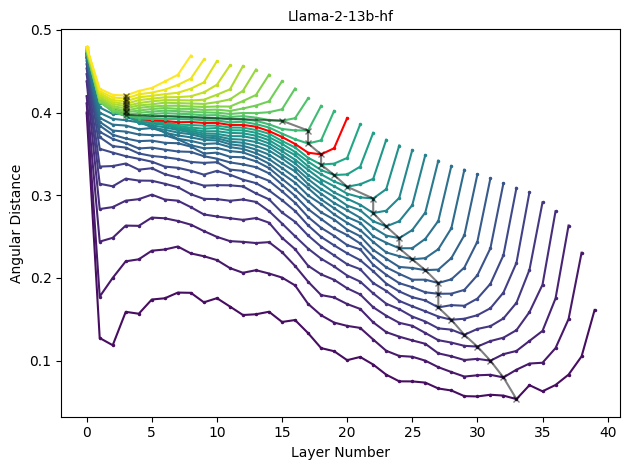

In [36]:
import matplotlib.pyplot as plt
import numpy as np

colors = plt.cm.viridis(np.linspace(0,1,1+len(step_list)))
x_min = []
y_min = []
plt.figure()#figsize=(5,2))
for step in step_list:
    # if step==1:
    #     fname = out_dir+ f"c4_{model_name.split('/')[-1]}_2.json"
    # else:
    #     fname = out_dir+ f"c4_{model_name.split('/')[-1]}_s_{step}_2.json"
    # last_token_sim_step =  file_reader(fname)
    x = np.arange(num_layers-step+1)
    y =  np.arccos(similarity[f"{step}"].numpy()).mean(axis=0)/np.pi
    idx_min = np.argmin(y)
    x_min.append(x[idx_min])
    y_min.append(y[idx_min])
    if step == num_layers//2:
        plt.plot(x, y,"r.-", markersize=3,linewidth=1.5,label=f"{step}")
    else:
        plt.plot(x, y,".-", markersize=3,linewidth=1.5,color=colors[step],label=f"{step}")
    # plt.plot(x, y,".-", markersize=3,linewidth=1.5,label=f"{step}")

plt.plot(x_min,y_min,"kx-",markersize=4,alpha=0.5)
plt.xlabel("Layer Number")# (similarity btw in and out of [x,x+1,x+2])")
plt.ylabel("Angular Distance")
plt.title(f"{model_name.split('/')[-1]}", fontsize= 10)
# plt.grid()
# plt.xlim(15.5,27.5)
# plt.ylim(0.05,0.25)
# plt.legend(bbox_to_anchor=(1.2, 1.0))
plt.tight_layout()
# plt.savefig(f"c4_{model_name.split('/')[-1]}.png")
plt.show()

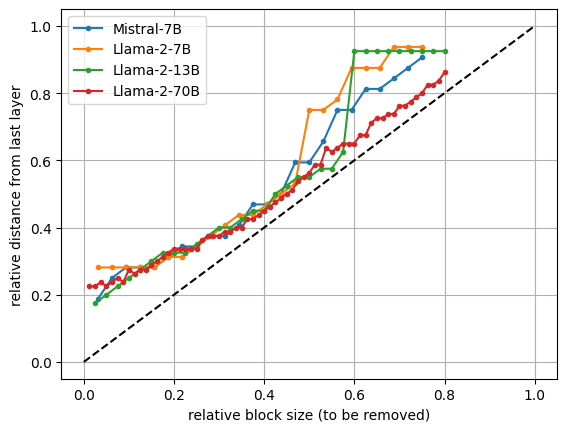

In [30]:
x_min_llama_2_7b = []
x_min_llama_2_13b = [33, 32, 31, 30, 29, 28, 27, 27, 27, 26, 25, 24, 24, 23, 22, 22, 20, 19, 18, 18, 17, 17, 15, 3, 3, 3, 3, 3, 3, 3, 3, 3]
x_min_llama_2_70b = [62, 62, 61, 62, 61, 60, 61, 58, 59, 58, 58, 57, 56, 55, 54, 53, 53, 53, 53, 53, 51, 50, 50, 50, 49, 49, 48, 48, 46, 46, 45, 44, 43, 42, 41, 40, 39, 37, 36, 35, 33, 33, 29, 30, 29, 28, 28, 28, 26, 26, 23, 22, 22, 21, 21, 19, 19, 18, 17, 16, 14, 14, 13, 11]
# [33, 32, 31, 30, 29, 28, 27, 27, 27, 26, 25, 24, 24, 23, 22, 22, 20, 19, 18, 18, 17, 17, 15, 3]
x_min_mistral = [26, 24, 23, 23, 23, 22, 21, 21, 20, 20, 19, 17, 17, 16, 13, 13, 11, 8, 8, 6, 6, 5, 4, 3]
x_min_llama_2_7b = [23, 23, 23, 23, 23, 22, 22, 21, 20, 19, 18, 18, 17, 16, 15, 8, 8, 7, 4, 4, 4, 2, 2, 2]
plt.plot(np.arange(1,1+len(x_min_mistral))/32, 1-np.array(x_min_mistral)/32,".-",label="Mistral-7B")
plt.plot(np.arange(1,1+len(x_min_llama_2_7b))/32, 1-np.array(x_min_llama_2_7b)/32,".-",label="Llama-2-7B")
plt.plot(np.arange(1,1+len(x_min_llama_2_13b))/40, 1-np.array(x_min_llama_2_13b)/40,".-",label="Llama-2-13B")
plt.plot(np.arange(1,1+len(x_min_llama_2_70b))/80, 1-np.array(x_min_llama_2_70b)/80,".-",label="Llama-2-70B")
x_plot = [0,1]
plt.plot(x_plot,x_plot,"k--")
plt.ylabel("relative distance from last layer")
plt.xlabel("relative block size (to be removed)")
plt.grid()
plt.legend()
plt.show()

In [32]:
print(x_min)

[33, 32, 31, 30, 29, 28, 27, 27, 27, 26, 25, 24, 24, 23, 22, 22, 20, 19, 18, 18, 17, 17, 15, 3, 3, 3, 3, 3, 3, 3, 3, 3]


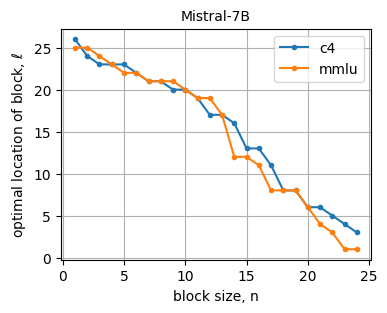

In [32]:
import matplotlib.pyplot as plt
import numpy as np

## dependence on dataset
x_min_mistral = [26, 24, 23, 23, 23, 22, 21, 21, 20, 20, 19, 17, 17, 16, 13, 13, 11, 8, 8, 6, 6, 5, 4, 3]
# x_min_mistral = [26, 24, 23, 23, 23, 22, 21, 21, 20, 20, 19, 17, 17, 16, 13, 13, 8, 8, 8, 6, 6, 5, 4, 3]
x_min_mmlu = [25, 25, 24, 23, 22, 22, 21, 21, 21, 20, 19, 19, 17, 12, 12, 11, 8, 8, 8, 6, 4, 3, 1, 1]

plt.figure(figsize=(4,3))
plt.plot(np.arange(1,1+len(x_min_mistral)), np.array(x_min_mistral),".-",label="c4")
plt.plot(np.arange(1,1+len(x_min_mmlu)), np.array(x_min_mmlu),".-",label="mmlu")
plt.ylabel(r"optimal location of block, $\ell$")
plt.xlabel("block size, n")
plt.title("Mistral-7B", fontsize=10)
plt.grid()
plt.legend()
plt.show()


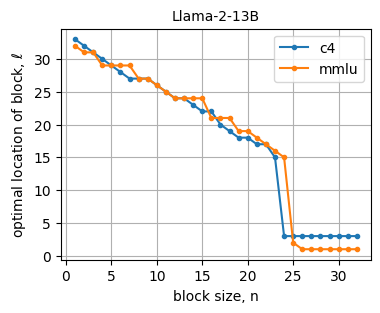

In [28]:
x_min_llama_2_13b_2 = [33, 32, 31, 30, 29, 28, 27, 27, 27, 26, 25, 24, 24, 23, 22, 22, 20, 19, 18, 18, 17, 17, 15, 3, 3, 3, 3, 3, 3, 3, 3, 3]
x_min_llama_2_13b = [33, 32, 31, 30, 29, 28, 27, 27, 27, 26, 25, 24, 24, 23, 22, 22, 20, 19, 18, 18, 17, 17, 15, 3, 3, 3, 3, 3, 3, 3, 3, 3]
x_min_llama_2_13b_mmlu = [32, 31, 31, 29, 29, 29, 29, 27, 27, 26, 25, 24, 24, 24, 24, 21, 21, 21, 19, 19, 18, 17, 16, 15, 2, 1, 1, 1, 1, 1, 1, 1]

plt.figure(figsize=(4,3))
# plt.plot(np.arange(1,1+len(x_min_llama_2_13b))/40, 1-np.array(x_min_llama_2_13b)/40,".-",label="c4")
# plt.plot(np.arange(1,1+len(x_min_llama_2_13b_2))/40, 1-np.array(x_min_llama_2_13b_2)/40,".-",label="c4")
# plt.plot(np.arange(1,1+len(x_min_llama_2_13b_mmlu))/40, 1-np.array(x_min_llama_2_13b_mmlu)/40,".-",label="mmlu")
plt.plot(np.arange(1,1+len(x_min_llama_2_13b_2)), np.array(x_min_llama_2_13b_2),".-",label="c4")
plt.plot(np.arange(1,1+len(x_min_llama_2_13b_mmlu)), np.array(x_min_llama_2_13b_mmlu),".-",label="mmlu")
# x_plot = [0,1]
# plt.plot(x_plot,x_plot,"k--")
plt.ylabel(r"optimal location of block, $\ell$")
plt.xlabel("block size, n")
plt.title("Llama-2-13B", fontsize=10)
plt.grid()
plt.legend()
plt.show()